## 1 Data Preprocessing

In [5]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from dtaidistance import dtw
from scipy.signal import correlate
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from time import sleep
import math

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# target information (IMPORTANT!)
target_symbol = 'GBPUSD'
target_timeframe = 'H1'
optional_plot = False

interval_tf1 = { 'M5': Interval.in_5_minute,
                 'M15': Interval.in_15_minute,
                 'H1': Interval.in_1_hour,
                 'H4': Interval.in_4_hour,
                 'D1': Interval.in_daily,
                 'W1': Interval.in_weekly }

interval_tf2 = { 'M5': Interval.in_1_minute,
                 'M15': Interval.in_5_minute,
                 'H1': Interval.in_15_minute,
                 'H4': Interval.in_1_hour,
                 'D1': Interval.in_4_hour,
                 'W1': Interval.in_daily }

time_unit = { 'M5': 'Minute',
              'M15': 'Hour',
              'H1': 'Hour',
              'H4': 'Hour',
              'D1': 'Day', 
              'W1': 'Week' }


# Fetch historical data for the target symbol
forex_data = tv.get_hist(symbol=target_symbol, exchange='ICMARKETS',
                              interval=interval_tf1[target_timeframe], n_bars=4000)

sleep(1)

# Fetch lower timeframe data for TFO
forex_data_lowertf = tv.get_hist(symbol=target_symbol, exchange='ICMARKETS',
                              interval=interval_tf2[target_timeframe], n_bars=1000)

prices = forex_data['close']
print(prices)

# Save the original time index
original_time_index = prices.index

# Reset the index to 0 to 999
prices = prices.reset_index(drop=True)

ERROR:tvDatafeed.main:error while signin


datetime
2024-04-01 14:01:00    1.26162
2024-04-01 15:01:00    1.26124
2024-04-01 16:01:00    1.25872
2024-04-01 17:01:00    1.25623
2024-04-01 18:01:00    1.25423
                        ...   
2024-11-21 07:01:00    1.26501
2024-11-21 08:01:00    1.26501
2024-11-21 09:01:00    1.26470
2024-11-21 10:01:00    1.26378
2024-11-21 11:01:00    1.26364
Name: close, Length: 4000, dtype: float64


In [ ]:
forex_data_lowertf['close'][-20:]

In [2]:
# Apply Savitzky-Golay filter to get the trend
# Note that in scipy Savitzky-Golay filter, the last elements are calculated by padding,
# so we would remove them to ensure an accurate trend data

yvalues_trend = []
yvalues_seasonal = []

yvalues = prices[:-310]
yvalues_trend.append(savgol_filter(yvalues,19,1))
yvalues_trend.append(savgol_filter(yvalues_trend[0],59,1))
yvalues_trend.append(savgol_filter(yvalues_trend[1],179,1))
yvalues_seasonal.append(yvalues-yvalues_trend[0])
yvalues_seasonal.append(yvalues_trend[0]-yvalues_trend[1])
yvalues_seasonal.append(yvalues_trend[1]-yvalues_trend[2])

yvalues_trend_forecast    = [None] * 3
yvalues_seasonal_forecast = [None] * 3
results_trend             = [None] * 3
results_seasonal          = [None] * 3

In [ ]:
# Optional: Plot the decomposed time series
if (optional_plot):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(np.arange(-800,0), yvalues[-800:], label='Original input',linewidth=3)
    ax.plot(np.arange(-800,0), yvalues_trend[0][-800:], label='Trend Component')
    ax.plot(np.arange(-800,0), yvalues_trend[1][-800:], label='Meta Trend Component')
    ax.plot(np.arange(-800,0), yvalues_trend[2][-800:], label='Macro Trend Component')
    ax.legend()
    ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
    plt.tight_layout()
    plt.show()

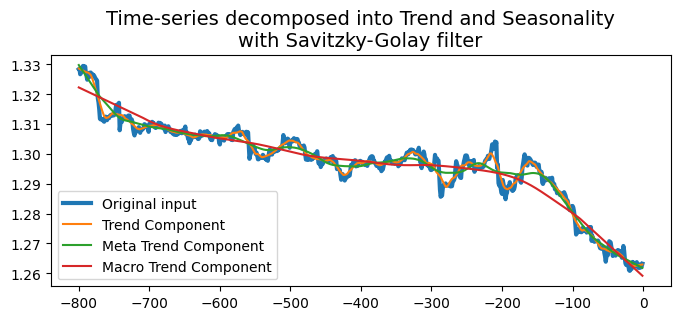

In [6]:
import tkinter as tk
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Example price data
N = 10  # Initial value of N

# Function to calculate trend components
def calculate_trends(N):
    end_index = len(prices) - N
    start_index = end_index - 800
    if start_index < 0:
        # Pad with the first value to maintain length
        padding_length = -start_index
        yvalues = np.pad(prices[:end_index], (padding_length, 0), 'edge')
    else:
        yvalues = prices[start_index:end_index]

    yvalues_trend = []
    yvalues_trend.append(savgol_filter(yvalues, 19, 1))
    yvalues_trend.append(savgol_filter(yvalues_trend[0], 59, 1))
    yvalues_trend.append(savgol_filter(yvalues_trend[1], 179, 1))

    return yvalues, yvalues_trend

# Function to update the plot
def update_plot():
    global N
    yvalues, yvalues_trend = calculate_trends(N)

    ax.clear()
    x_values = np.arange(-800, 0)
    ax.plot(x_values, yvalues, label='Original input', linewidth=3)
    ax.plot(x_values, yvalues_trend[0], label='Trend Component')
    ax.plot(x_values, yvalues_trend[1], label='Meta Trend Component')
    ax.plot(x_values, yvalues_trend[2], label='Macro Trend Component')
    ax.legend()
    ax.set_title('Time-series decomposed into Trend and Seasonality\nwith Savitzky-Golay filter', fontsize=14)
    canvas.draw()

    # Update the label showing the value of N
    n_label.config(text=f"Current N: {N}, Time: {forex_data.index[-N]}")

# Button callbacks to adjust N
def increase_N_by_10():
    global N
    if N + 10 < len(prices):
        N += 10
        update_plot()

def increase_N_by_1():
    global N
    if N + 1 < len(prices):
        N += 1
        update_plot()

def decrease_N_by_1():
    global N
    if N > 1:
        N -= 1
        update_plot()

def decrease_N_by_10():
    global N
    if N > 10:
        N -= 10
        update_plot()

# Tkinter GUI setup
root = tk.Tk()
root.title("Adjust N for Time-Series Decomposition")

# Create the figure and initial plot
fig, ax = plt.subplots(figsize=(8, 3))
yvalues, yvalues_trend = calculate_trends(N)
x_values = np.arange(-800, 0)
ax.plot(x_values, yvalues, label='Original input', linewidth=3)
ax.plot(x_values, yvalues_trend[0], label='Trend Component')
ax.plot(x_values, yvalues_trend[1], label='Meta Trend Component')
ax.plot(x_values, yvalues_trend[2], label='Macro Trend Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\nwith Savitzky-Golay filter', fontsize=14)

# Embed the plot in Tkinter
canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(fill=tk.BOTH, expand=True)

# Add a label to display the current value of N
n_label = tk.Label(root, text=f"Current N: {N}, Time: {forex_data.index[-N]}", font=("Arial", 14))
n_label.pack(pady=5)

# Add buttons to control N
button_frame = tk.Frame(root)
button_frame.pack(fill=tk.X)

btn_increase_10 = tk.Button(button_frame, text="+10", command=increase_N_by_10, width=8)
btn_increase_10.pack(side=tk.LEFT, padx=5, pady=5)

btn_increase_1 = tk.Button(button_frame, text="+1", command=increase_N_by_1, width=8)
btn_increase_1.pack(side=tk.LEFT, padx=5, pady=5)

btn_decrease_1 = tk.Button(button_frame, text="-1", command=decrease_N_by_1, width=8)
btn_decrease_1.pack(side=tk.LEFT, padx=5, pady=5)

btn_decrease_10 = tk.Button(button_frame, text="-10", command=decrease_N_by_10, width=8)
btn_decrease_10.pack(side=tk.LEFT, padx=5, pady=5)

# Run the application
root.mainloop()
